In [7]:
include("../output.jl")
using ImpvolOutput, CSV, FileIO, Plots
gr()
default(fmt = :png)
parameters = load("../experiments/baseline/common_parameters.jld2")["parameters"]

Dict{Symbol,Any} with 45 entries:
  :S_nt                     => [0.0 0.0 … 0.0 0.0]…
  :one_over_rho             => 0.0
  :inner_tolerance          => 0.0002
  :S_nt_data                => [1184.95 -1239.14 … -406.84 1074.1]…
  :eta                      => 4.0
  :S                        => 101
  :sigma                    => 0.999
  :d                        => [0.991383 7.85e-7 … 0.000689 0.0004425; 7.42e-5 …
  :adjustment_tolerance     => 0.0004
  :middle_step_size         => 0.449329
  :A_njs                    => Array{Float64,4}[[1466.0 503.069 … 1568.37 7165.…
  :gamma_jk                 => [0.17112 0.273944 … 0.0195213 0.0108426; 0.04826…
  :p_sectoral               => [1.26077 2.37256 … 1.79398 1.0]…
  :B_j                      => [5.5087]…
  :max_iter_adjustment      => 100
  :w_njt                    => [53118.2 20374.8 … 1.48903e5 1.12031e6]…
  :global_sectoral_shock    => [6.93889e-15]…
  :country_shock_njs        => Array{Float64,4}[[-5.65899e-17 -6.22493e-16 … 1.…
  :idi

In [8]:
function load_GDP(scenario)
    if scenario=="data"
        data = load("../data/impvol_data.jld2")
        cpi = CSV.read("../data/cpi.csv")
        us_cpi = reshape(cpi[:,end] ./ cpi[1,end], (1,1,1,36))
        dollar_price_index = data["pwt"] .* us_cpi
        return (sum(data["va"], 3) ./ dollar_price_index)[1,:,1,:]'
    else
        results = load("../experiments/$scenario/results.jld2")["results"]
        return sum(ImpvolOutput.make_series(results, :real_GDP), 3)[1,:,1,:]'
    end
end

load_GDP (generic function with 1 method)

In [9]:
function compare(scenarios, country, detrend=false)
    country_names = CSV.read("../experiments/baseline/output_table.csv")[:country_names]
    X = zeros(36, length(scenarios))
    if country==0
        name = "World"
    else
        name = country_names[country]
    end
    for s = 1:length(scenarios)
        GDP = log.(load_GDP(scenarios[s]))
        if detrend
          GDP, _ = ImpvolOutput.DetrendUtilities.detrend(GDP',parameters[:bp_weights])
            GDP = GDP'
        end
        if country==0
            X[:,s] .= log.(sum(exp.(GDP), 2)[:,1])
        else
            X[:,s] .= GDP[:,country]
        end
        println(var(X[:,s]))
    end
    plot(X, label=scenarios, title=name)
end

compare (generic function with 2 methods)

In [10]:
# France

0.02564595397452325
0.0687389087060393


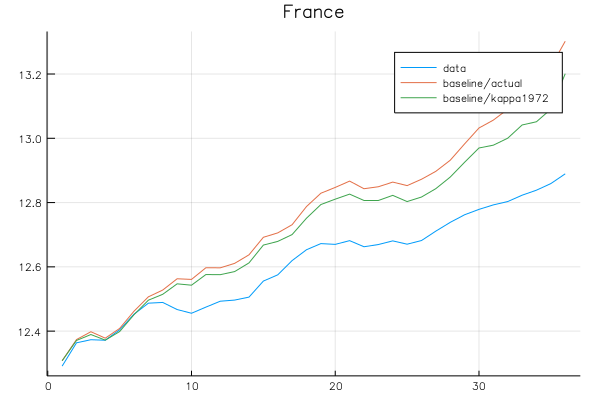

0.053354793073579376


In [11]:
compare(["data", "baseline/actual", "baseline/kappa1972"], 9)

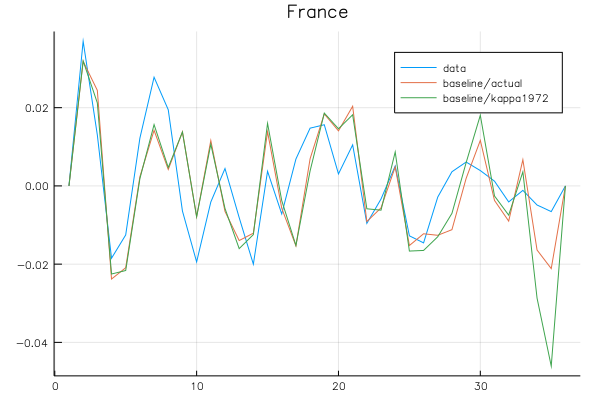

0.00015963334184240614
0.00019587314714017694
0.00026196048785487167


In [12]:
compare(["data", "baseline/actual", "baseline/kappa1972"], 9, true)

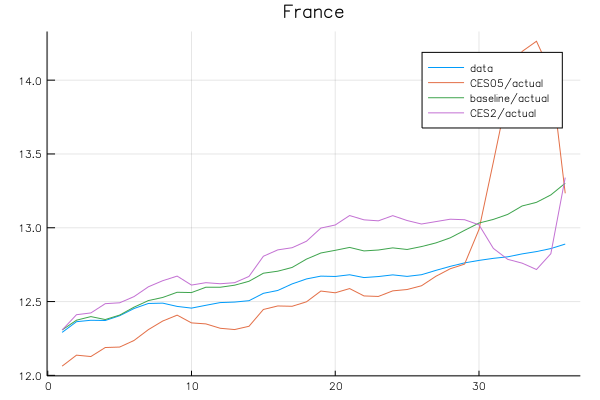

0.02564595397452325
0.3441834310213427
0.0687389087060393
0.05915777839177309


In [18]:
compare(["data", "CES05/actual", "baseline/actual", "CES2/actual"], 9, false)

0.06723223408492926
0.1181736394402314
0.12869469221789934


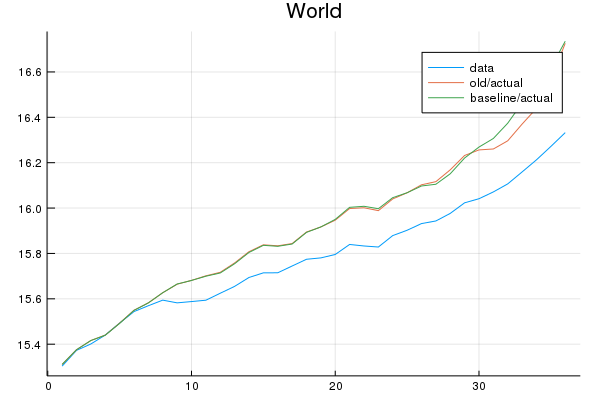

In [99]:
# whole world
compare(["data", "old/actual", "baseline/actual"], 0)

0.060733793617174
0.04854124835180049


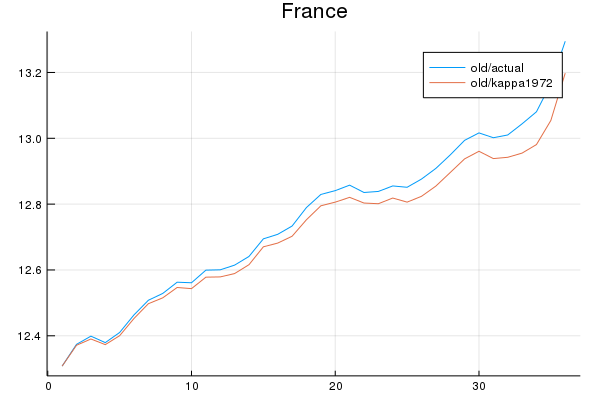

In [57]:
compare(["old/actual", "old/kappa1972"], 9)